In [1]:
#Packages Imports
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re

from growthlab_utils.connect_python_hive import read_hive_table
from nltk.stem import WordNetLemmatizer
from os import path
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

In [157]:
#Get The Data

#Depending on whether you want to search either by "id" or by "name"
m_select = "id"

#Depending on what you're interested in: "artist", "song"
m_type = "artist"

#on peut mettre both artist id, name, si plueisures : mettre id, id,id
#name à mettre en lower
m_ref = "4388"

In [158]:
#ID + Artist
if (m_select == "id" and m_type == "artist"):
    request = "SELECT regexp_replace(a.lyrics_text, '[\\n\\r\\t]', '') AS lyrics_text FROM (SELECT lyrics_id, lyrics_text FROM catalog.index_lyrics) AS a INNER JOIN (SELECT sng_id, lyrics_id FROM catalog.index_lyrics_song) AS b ON a.lyrics_id = b.lyrics_id INNER JOIN (SELECT sng_id, art_id FROM dwh.song WHERE art_id in ("+ m_ref +")) AS c ON b.sng_id = c.sng_id GROUP BY  lyrics_text"
elif (m_select == "name" and m_type == "artist"):
    request = "SELECT regexp_replace(a.lyrics_text, '[\\n\\r\\t]', '') AS lyrics_text FROM (SELECT lyrics_id, lyrics_text FROM catalog.index_lyrics) AS a INNER JOIN (SELECT sng_id, lyrics_id FROM catalog.index_lyrics_song) AS b ON a.lyrics_id = b.lyrics_id INNER JOIN (SELECT sng_id, art_id, art_name FROM dwh.song WHERE lower(art_name) like '"+ m_ref +"') AS c ON b.sng_id = c.sng_id GROUP BY  lyrics_text"
elif (m_select == "id" and m_type == "song"): #poss de mettre plusieurs id car wher ein
    request = "SELECT b.sng_id AS sng_id, a.lyrics_id AS lyrics_id, regexp_replace(a.lyrics_text, '[\\n\\r\\t]', '') AS lyrics_text FROM (SELECT lyrics_id, lyrics_text FROM catalog.index_lyrics GROUP BY  lyrics_id, lyrics_text) AS a INNER JOIN (SELECT sng_id, lyrics_id FROM catalog.index_lyrics_song WHERE sng_id IN (" + m_ref + ") GROUP BY  sng_id, lyrics_id) AS b ON a.lyrics_id = b.lyrics_id"
elif (m_select =="id" and m_type == "album"):
    request = "SELECT b.sng_id AS sng_id, a.lyrics_id AS lyrics_id, regexp_replace(a.lyrics_text, '[\\n\\r\\t]', '') AS lyrics_text FROM (SELECT lyrics_id, lyrics_text FROM catalog.index_lyrics GROUP BY  lyrics_id, lyrics_text) AS a INNER JOIN (SELECT sng_id, lyrics_id FROM catalog.index_lyrics_song GROUP BY  sng_id, lyrics_id) AS b ON a.lyrics_id = b.lyrics_id INNER JOIN (SELECT * FROM dwh.song WHERE alb_id in (" + m_ref + ")) AS c ON b.sng_id = c.sng_id"
else:
    print "bug"
    request = None

In [363]:
request = "select lyrics_text from (select lower(sng_title), min(lyrics_text) as lyrics_text from (SELECT sng_title, regexp_replace(a.lyrics_text, '[\\n\\r\\t]', '') AS lyrics_text FROM (SELECT lyrics_id, lyrics_text FROM catalog.index_lyrics) AS a INNER JOIN (SELECT sng_id, lyrics_id FROM catalog.index_lyrics_song) AS b ON a.lyrics_id = b.lyrics_id INNER JOIN (SELECT sng_title, sng_id, art_id FROM dwh.song WHERE art_id = 405) AS c ON b.sng_id = c.sng_id) as t1 group by lower(sng_title)) as t2 group by lyrics_text"

In [364]:
data = read_hive_table(request)

[HIVE REQUEST] EXECUTE REQUEST FROM HIVE: RUNNING (can take a bit of time)
[HIVE REQUEST] EXECUTE REQUEST FROM HIVE: SUCCESS


In [275]:
pd.options.display.max_colwidth = 200
data.head()

,lyrics_text
0,"""You're so free,"" that's what everybody's telling me Yet I feel I'm like an outward-bound, pushed around, refugee Something's wrong, got a feeling that I don't belong As if I had come from oute..."
1,"(b. andersson, b. ulv&aelig;us) Scaramouche (instrumental) Varf&ouml;r ska det vara s&aring; seri&ouml;st f&ouml;r, alltid? N&auml;, I england sl&aring;r det s&auml;ckert. N&auml;, det k&au..."
2,"Agnetha We're not the stars of a Hollywood movie So what's the use to pretend I'm not so charming and you're not so groovy You've got to face it my friend Agnetha, Frida Dreamworld, you'..."
3,"Agnetha, Frida Early this morning I drove in the rain Out to the airport to get on the plain Hey Honolulu, I'm going to happy Hawaii Alice has been there, she said it was fun Swimming and s..."
4,Are you sure you want to hear more What if I ain't worth the while Not the style you'd be looking for If I'm sweet tonight Things look different in the morning light I'm jealous and I'm proud...


In [365]:
#DATA CLEANING
all_lyrics = ""
for index, row in data.iterrows():
    lyrics_decoded = row['lyrics_text'].lower().decode("utf-8", "replace")
    lyrics_no_backslash = lyrics_decoded.replace("\"", "")
    all_lyrics = all_lyrics + " " + lyrics_no_backslash

In [52]:
all_lyrics

u" i'm the sheik of araby,   your love belongs to me.  at night when you're asleep   into your tent i'll creep.  the stars that shine above,  will light our way to love.  you'll rule this land with me; (help) i need somebody  (help) not just anybody  (help) you know i need someone  (help)    (when) when i was younger (when i was young) so much younger than today  (i never needed) i never needed anybody's help in any way  (now) but now these days are gone (these days are gone) i'm not so self-assured (and now i find)  now i find i've changed my mind, i've opened up the doors    help me if you can, i'm feeling down  and i do appreciate you being 'round  help me get my feet back on the ground  won't you please, please help me?    (now) and now my life has changed (my life has changed) in oh-so-many ways (my independence)  my independence seems to vanish in the haze  (but) but every now and then (now and then) i feel so insecure (i know that i)  i know that i just need you like i never don

In [84]:
#LOOKING AT THE 10 MOST COMMON WORDS
from collections import Counter

#Tokenizing
tok = nltk.tokenize.word_tokenize(all_lyrics)

#Couting words
cnt = Counter(tok)
cnt.most_common(10)

[(u',', 4140),
 (u'i', 3354),
 (u'you', 2913),
 (u'the', 2476),
 (u'to', 1613),
 (u'a', 1570),
 (u'me', 1347),
 (u'and', 1342),
 (u'it', 1275),
 (u"n't", 1195)]

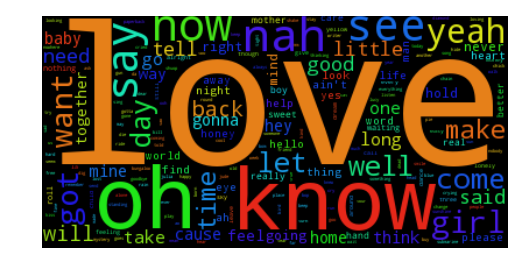

In [50]:
#Basic wordcloud generation test
wc = WordCloud().generate(all_lyrics)
plt.imshow(wc)
plt.axis("off")
plt.show()

In [366]:
tokens = nltk.tokenize.word_tokenize(all_lyrics)

In [54]:
tokens

[u'i',
 u"'m",
 u'the',
 u'sheik',
 u'of',
 u'araby',
 u',',
 u'your',
 u'love',
 u'belongs',
 u'to',
 u'me',
 u'.',
 u'at',
 u'night',
 u'when',
 u'you',
 u"'re",
 u'asleep',
 u'into',
 u'your',
 u'tent',
 u'i',
 u"'ll",
 u'creep',
 u'.',
 u'the',
 u'stars',
 u'that',
 u'shine',
 u'above',
 u',',
 u'will',
 u'light',
 u'our',
 u'way',
 u'to',
 u'love',
 u'.',
 u'you',
 u"'ll",
 u'rule',
 u'this',
 u'land',
 u'with',
 u'me',
 u';',
 u'(',
 u'help',
 u')',
 u'i',
 u'need',
 u'somebody',
 u'(',
 u'help',
 u')',
 u'not',
 u'just',
 u'anybody',
 u'(',
 u'help',
 u')',
 u'you',
 u'know',
 u'i',
 u'need',
 u'someone',
 u'(',
 u'help',
 u')',
 u'(',
 u'when',
 u')',
 u'when',
 u'i',
 u'was',
 u'younger',
 u'(',
 u'when',
 u'i',
 u'was',
 u'young',
 u')',
 u'so',
 u'much',
 u'younger',
 u'than',
 u'today',
 u'(',
 u'i',
 u'never',
 u'needed',
 u')',
 u'i',
 u'never',
 u'needed',
 u'anybody',
 u"'s",
 u'help',
 u'in',
 u'any',
 u'way',
 u'(',
 u'now',
 u')',
 u'but',
 u'now',
 u'these',
 u'days

In [717]:
#stoplist = ["a","about","above","after","again","against","all","am","an","and","any","are","aren't","as","at","be","because","been","before","being","below","between","both","but","by","can","can't","cannot","com","could","couldn't","did","didn't","do","does","doesn't","doing","don't","down","during","each","else","ever","few","for","from","further","get","had","hadn't","has","hasn't","have","haven't","having","he","he'd","he'll","he's","her","here","here's","hers","herself","him","himself","his","how","how's","http","i","i'd","i'll","i'm","i've","if","in","into","is","isn't","it","it's","its","itself","just","k","let's","like","me","more","most","mustn't","my","myself","no","nor","not","of","off","on","once","only","or","other","ought","our","ours ","ourselves","out","over","own","r","same","shall","shan't","she","she'd","she'll","she's","should","shouldn't","so","some","such","than","that","that's","the","their","theirs","them","themselves","then","there","there's","these","they","they'd","they'll","they're","they've","this","those","through","to","too","under","until","up","very","was","wasn't","we","we'd","we'll","we're","we've   ","were","weren't","what","what's","when","when's","where","where's","which","while","who","who's","whom","why","why's","with","won't","would","wouldn't","www","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves"]
#token = [word for word in tokens if word not in stoplist]

In [718]:
#lemmatizer = nltk.stem.WordNetLemmatizer()
#lemmatized_tokens_tmp = [lemmatizer.lemmatize(w, nltk.corpus.wordnet.NOUN) for w in tokens]

In [367]:
wnl = WordNetLemmatizer()
lemmatized_tokens = [wnl.lemmatize(word, 'v') for word in tokens]

In [56]:
lemmatized_tokens

[u'i',
 u"'m",
 u'the',
 u'sheik',
 u'of',
 u'araby',
 u',',
 u'your',
 u'love',
 u'belong',
 u'to',
 u'me',
 u'.',
 u'at',
 u'night',
 u'when',
 u'you',
 u"'re",
 u'asleep',
 u'into',
 u'your',
 u'tent',
 u'i',
 u"'ll",
 u'creep',
 u'.',
 u'the',
 u'star',
 u'that',
 u'shine',
 u'above',
 u',',
 u'will',
 u'light',
 u'our',
 u'way',
 u'to',
 u'love',
 u'.',
 u'you',
 u"'ll",
 u'rule',
 u'this',
 u'land',
 u'with',
 u'me',
 u';',
 u'(',
 u'help',
 u')',
 u'i',
 u'need',
 u'somebody',
 u'(',
 u'help',
 u')',
 u'not',
 u'just',
 u'anybody',
 u'(',
 u'help',
 u')',
 u'you',
 u'know',
 u'i',
 u'need',
 u'someone',
 u'(',
 u'help',
 u')',
 u'(',
 u'when',
 u')',
 u'when',
 u'i',
 u'be',
 u'younger',
 u'(',
 u'when',
 u'i',
 u'be',
 u'young',
 u')',
 u'so',
 u'much',
 u'younger',
 u'than',
 u'today',
 u'(',
 u'i',
 u'never',
 u'need',
 u')',
 u'i',
 u'never',
 u'need',
 u'anybody',
 u"'s",
 u'help',
 u'in',
 u'any',
 u'way',
 u'(',
 u'now',
 u')',
 u'but',
 u'now',
 u'these',
 u'days',
 u'be

In [368]:
joined = " ".join(lemmatized_tokens)

In [369]:
shortword = re.compile(r'\W*\b\w{1,2}\b')
lyrics_long = shortword.sub('', joined)

In [60]:
lyrics_long

u" the sheik araby , your love belong night when you asleep into your tent creep . the star that shine above , will light our way love . you rule this land with ; ( help need somebody ( help ) not just anybody ( help ) you know need someone ( help ) ( when ) when younger ( when young much younger than today never need never need anybody help any way ( now ) but now these days ( these days not self-assured ( and now find ) now find change mind open the doors help you can feel down and appreciate you 'round help get feet back the grind you please , please help ? ( now ) and now life have change life have change-many ways independence independence seem vanish the haze ( but ) but every now and then ( now and then feel insecure know that know that just need you like never before help you can feel down and appreciate you 'round help get feet back the grind you please , please help ? when younger much younger than today never need anybody help any way ( now ) but now these days ( these days 

In [370]:
lyrics_abrev = lyrics_long.replace("gon ", "go").replace("wan ", "want")

In [63]:
lyrics_abrev

u" the sheik araby , your love belong night when you asleep into your tent creep . the star that shine above , will light our way love . you rule this land with ; ( help need somebody ( help ) not just anybody ( help ) you know need someone ( help ) ( when ) when younger ( when young much younger than today never need never need anybody help any way ( now ) but now these days ( these days not self-assured ( and now find ) now find change mind open the doors help you can feel down and appreciate you 'round help get feet back the grind you please , please help ? ( now ) and now life have change life have change-many ways independence independence seem vanish the haze ( but ) but every now and then ( now and then feel insecure know that know that just need you like never before help you can feel down and appreciate you 'round help get feet back the grind you please , please help ? when younger much younger than today never need anybody help any way ( now ) but now these days ( these days 

In [382]:
#WORDCLOUD GENERATION SECTION
d = path.dirname('/home/margotlepizzera/Images/wordcloud/')

#Either choose a music_genre (among classical, country, dance, electro, hiphop, jazz, 
#latino, metal, reggae, reggaeton, rnb, rock, soul) and leave the artist_name variable empty ("")
#Or if you're willing to use a specific picture, leave the music_genre parameter empty (""),
#fill the artist_name parameter 
music_genre = "country"
artist_name = ""

if music_genre:
    mask = np.array(Image.open(path.join(d, "music genre/"+music_genre+".jpeg")))
elif not music_genre:
    mask = np.array(Image.open(path.join(d, "other images/"+artist_name+".jpg")))
else:
    print "bug"

In [383]:
wc = WordCloud(background_color="white", max_words=10000, mask=mask, random_state=42, 
               font_path="/home/margotlepizzera/Images/Roboto-Light.ttf")

In [384]:
wc.generate(lyrics_abrev)
image_colors = ImageColorGenerator(mask)

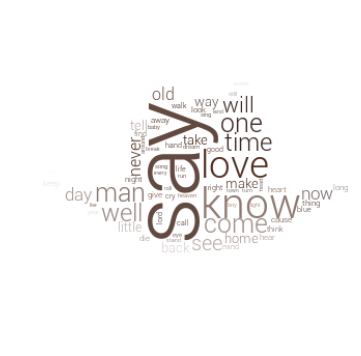

In [385]:
plt.imshow(wc.recolor(color_func=image_colors))
plt.axis("off")
plt.show()

In [375]:
#Store to file
p = path.dirname('/home/margotlepizzera/Images/wordcloud/wc_results/')
#Put your wordcloud name
wordcloud_name = "wc_cash"

wc.to_file(path.join(p, wordcloud_name+".jpg"))